In [1]:
import pandas as pd
from equipment.vdi.zbd import ZBD
from kid_readout.analysis import dataframe
plt.rcParams['font.size'] = 11

updated file list


:0: FutureWarning: IPython widgets are experimental and may change in the future.
/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def zbd_peak_voltage(lockin_rms_voltage):
    return 2**(-1/2) * np.pi * lockin_rms_voltage

def lockin_rms_voltage(zbd_peak_voltage):
    return 2**(1/2) / np.pi * zbd_peak_voltage

def zbd_power(lockin_rms_voltage, optical_frequency=None):
    if optical_frequency is None:
        return zbd_peak_voltage(lockin_rms_voltage) / 2200
    else:
        return zbd_peak_voltage(lockin_rms_voltage) / ZBD().responsivity(optical_frequency)

In [3]:
def rectangle(df, H1, L1, H2, L2):
    mask_H1 = df.mickey == H1
    mask_L1 = df.mickey == L1
    mask_H2 = df.minnie == H2
    mask_L2 = df.minnie == L2
    HH = df[mask_H1 & mask_H2]
    HL = df[mask_H1 & mask_L2]
    LH = df[mask_L1 & mask_H2]
    LL = df[mask_L1 & mask_L2]
    return HH, HL, LH, LL

def extract_all(rectangle, key='zbd_power'):
    extracted = []
    for HH, HL, LH, LL in rectangle:
        for dummy, row_HH in HH.iterrows():
            for dummy, row_HL in HL.iterrows():
                for dummy, row_LH in LH.iterrows():
                    for dummy, row_LL in LL.iterrows():
                        extracted.append((row_HH[key], row_HL[key],
                                          row_LH[key], row_LL[key],
                                          ((row_HH[key] * row_LL[key]) /
                                           (row_HL[key] * row_LH[key]))))
    return extracted

def plot_rectangles(rectangles):
    fig, ax = plt.subplots()
    for HH, HL, LH, LL, linearity in rectangles:
        ax.plot(sorted([1e6 * HH, 1e6 * HL, 1e6 * LH, 1e6 * LL]),
                4 * [linearity],
                '.-k', alpha=0.5)
    ax.set_xlabel('ZBD power [$\mu$W]')
    ax.set_ylabel('linearity')
    return fig, ax

In [4]:
df_filename = '/home/flanigan/equipment/vdi/calibration_broadband.npy'
df = pd.DataFrame().from_records(np.load(df_filename))

# Attempt to compensate for drift using a witness setting

In [5]:
df.sort('time', inplace=True)
mickey_witness = 120
minnie_witness = 120
witness = df[(df.mickey==mickey_witness) & (df.minnie==minnie_witness)]
first = witness[witness.time==witness.time.min()]
df['R_compensated'] = df.R / np.interp(df.time, witness.time, witness.R / first.iloc[0].R)

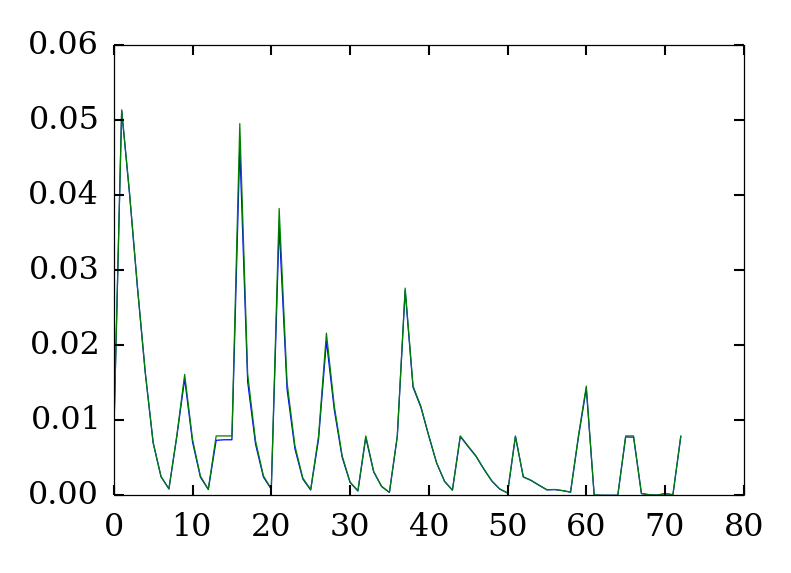

In [6]:
plt.plot(df.R)
plt.plot(df.R_compensated);

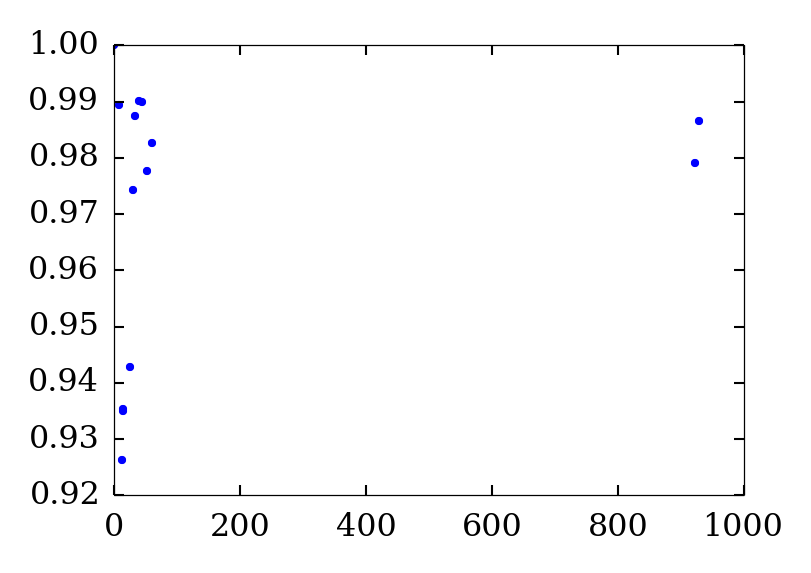

In [7]:
plt.plot((witness.time - witness.time.min()) / 60, witness.R / first.iloc[0].R, '.');

In [8]:
# This will use the standard responsivity of 2200 V / W:
optical_frequency = None

df['zbd_power_raw'] = zbd_power(df.R, optical_frequency)
df['zbd_power'] = zbd_power(df.R_compensated, optical_frequency)

minimum_linear_power = 1e-6
maximum_linear_power = 10e-6
df['is_linear'] =  ((df.zbd_power >= minimum_linear_power) &
                    (df.zbd_power <= maximum_linear_power))
df['is_linear_raw'] =  ((df.zbd_power_raw >= minimum_linear_power) &
                        (df.zbd_power_raw <= maximum_linear_power))

df['is_low'] = df.zbd_power < minimum_linear_power
df['is_high'] = df.zbd_power > maximum_linear_power

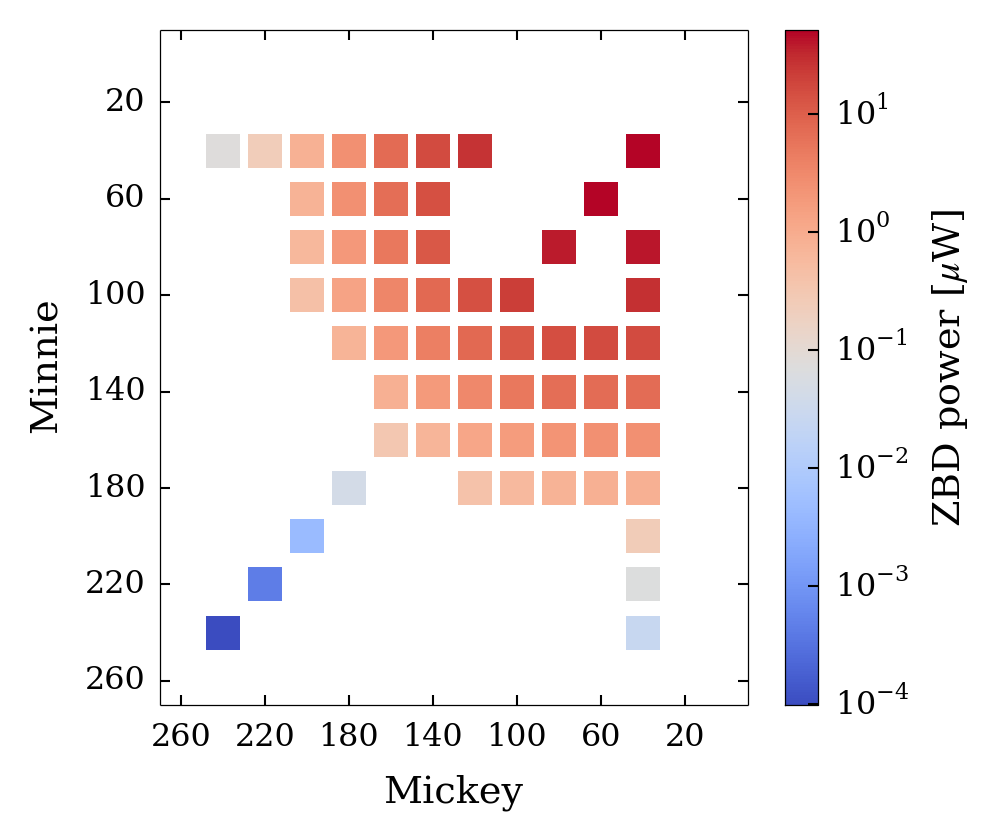

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 3))
data = 1e6 * df.zbd_power
norm = matplotlib.colors.LogNorm
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df.iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(1e6 * row.zbd_power),
            marker='s', markersize=8, markeredgecolor='none')
ax.set_xlim(270, -10)
ax.set_xticks(range(260, -20, -40))
ax.set_ylim(270, -10)
ax.set_yticks(range(260, -20, -40))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie')
fig.colorbar(mappable, label=r'ZBD power [$\mu$W]');

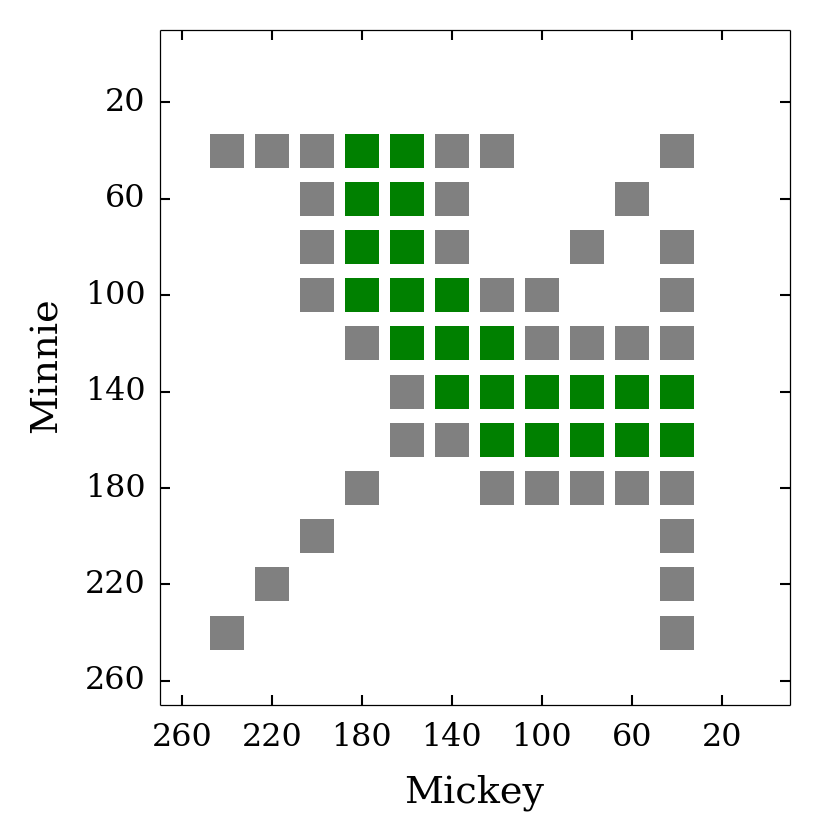

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df.mickey[df.is_linear], df.minnie[df.is_linear],
        color='green', marker='s', markersize=8, markeredgecolor='none', linestyle='none')
ax.plot(df.mickey[~df.is_linear], df.minnie[~df.is_linear],
        color='gray', marker='s', markersize=8, markeredgecolor='none', linestyle='none')
ax.set_xlim(270, -10)
ax.set_xticks(range(260, -20, -40))
ax.set_ylim(270, -10)
ax.set_yticks(range(260, -20, -40))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie');

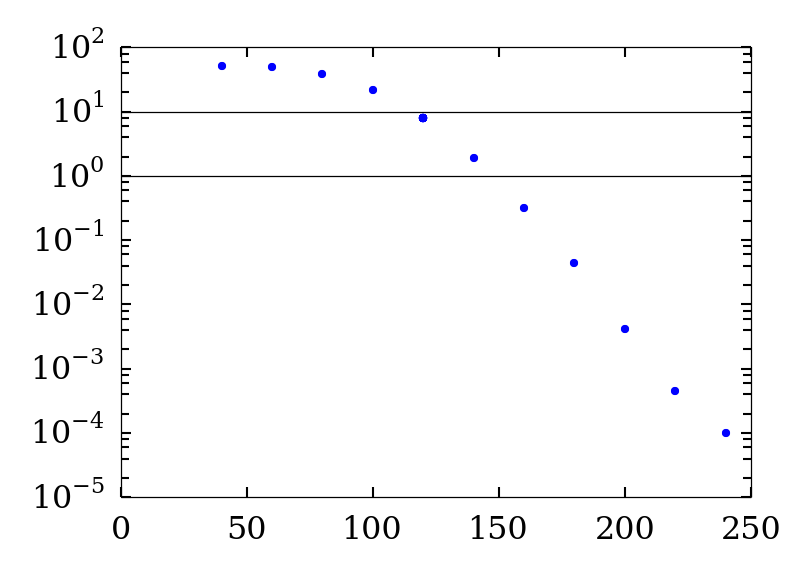

In [11]:
fig, ax = plt.subplots()
ax.axhline(1, color='k')
ax.axhline(10, color='k')
ax.semilogy(df[df.minnie==df.mickey].mickey, 1e6 * df[df.minnie==df.mickey].zbd_power, '.');

# Look at the effect of compensation

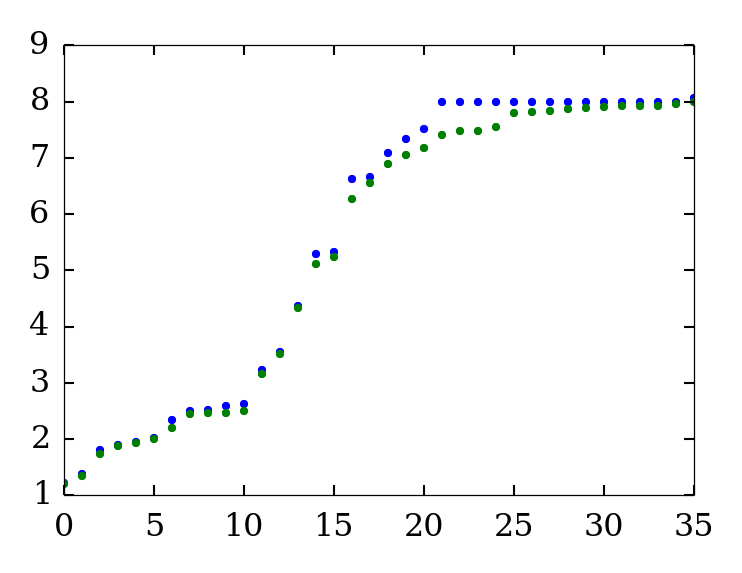

In [12]:
plt.plot(sorted(1e6 * df[df.is_linear].zbd_power), '.')
plt.plot(sorted(1e6 * df[df.is_linear_raw].zbd_power_raw), '.')

# Examine the data in the nominally linear region

In [13]:
linear_rectangles = []
mickey_unique = np.unique(df.mickey)
minnie_unique = np.unique(df.minnie)

for H1 in mickey_unique:
    for L1 in mickey_unique[mickey_unique > H1]:
        for H2 in minnie_unique:
            for L2 in minnie_unique[minnie_unique > H2]:
                HH, HL, LH, LL = rectangle(df[df.is_linear], H1, L1, H2, L2)
                if not HH.empty and not HL.empty and not LH.empty and not LL.empty:
                    linear_rectangles.append((HH.iloc[0].zbd_power,
                                              HL.iloc[0].zbd_power,
                                              LH.iloc[0].zbd_power,
                                              LL.iloc[0].zbd_power,
                                              ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                               (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))))

In [14]:
len(linear_rectangles)

18

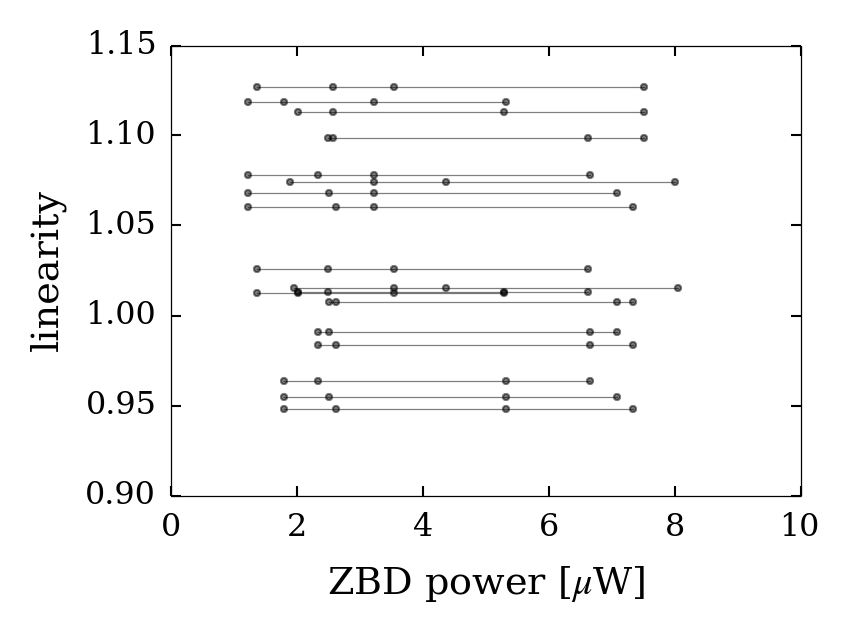

In [15]:
fig, ax = plot_rectangles(linear_rectangles)
ax.set_xlim(0, 10);

In [16]:
HHs = []
HLs = []
LHs = []
LLs = []
linearities = []
for rect in linear_rectangles:
    HHs.append(rect[0])
    HLs.append(rect[1])
    LHs.append(rect[2])
    LLs.append(rect[3])
    linearities.append(rect[4])
HHs = np.array(HHs)
HLs = np.array(HLs)
LHs = np.array(HLs)
LLs = np.array(LLs)
linearities = np.array(linearities)

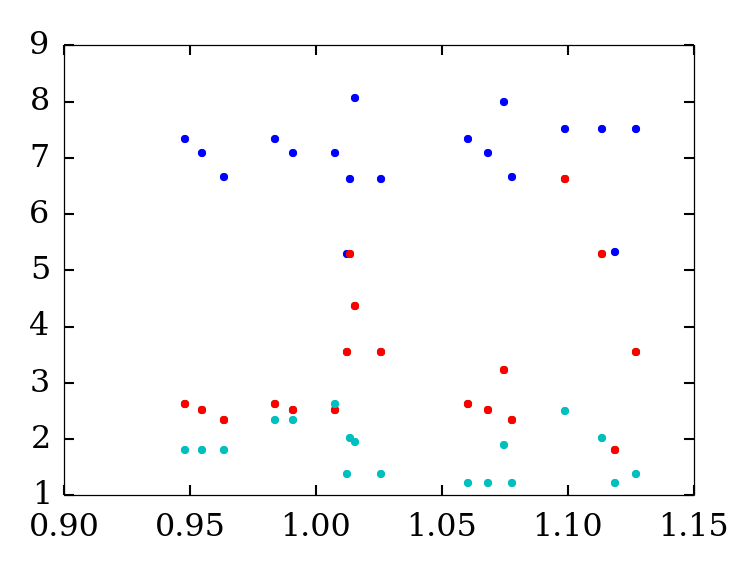

In [17]:
plt.plot(linearities, 1e6 * HHs, '.', label='HH')
plt.plot(linearities, 1e6 * HLs, '.', label='HL')
plt.plot(linearities, 1e6 * LHs, '.', label='LH')
plt.plot(linearities, 1e6 * LLs, '.', label='LL')

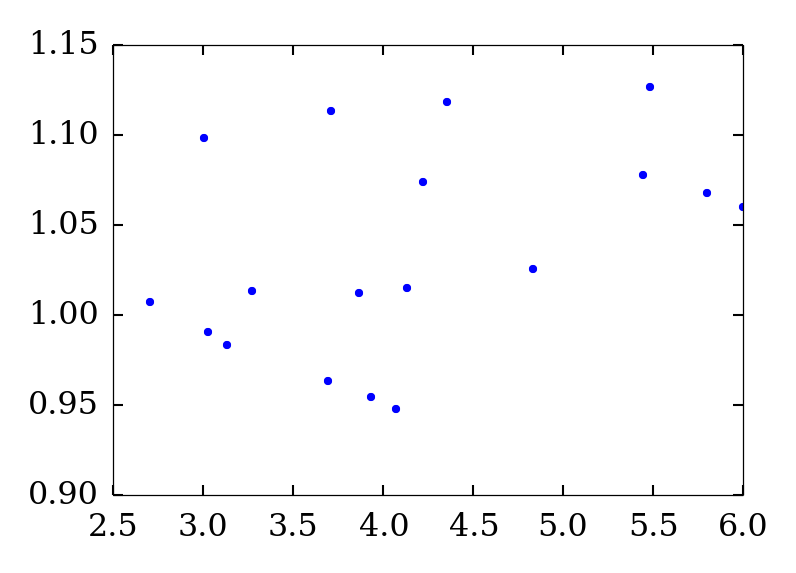

In [18]:
plt.plot(HHs / LLs, linearities, '.')

Take the linearity in the nominally linear region to be 1:

In [19]:
df.loc[df.is_linear, 'linearity'] = 1.
df.loc[df.is_linear, 'linearity_error'] = 0.
df.loc[df.is_linear, 'zbd_power_linear'] = (df[df.is_linear].zbd_power /
                                            df[df.is_linear].linearity)

# Calibrate the low-power points using the linear region

In [20]:
low_rectangles = []
linear_mickey = np.unique(df[df.is_linear].mickey)
linear_minnie = np.unique(df[df.is_linear].minnie)
for index, row in df[df.is_low].iterrows():
    row_linearity = []
    for H1 in linear_mickey[linear_mickey < row.mickey]:
        for H2 in linear_minnie[linear_minnie < row.minnie]:
            HH, HL, LH, LL = rectangle(df, H1, row.mickey, H2, row.minnie)
            try:
                # If the three other points are in the linear region, calibrate LL.
                if (HH.iloc[0].is_linear and
                    HL.iloc[0].is_linear and
                    LH.iloc[0].is_linear):
                    linearity = ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                 (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))
                    low_rectangles.append((HH.iloc[0].zbd_power,
                                           HL.iloc[0].zbd_power,
                                           LH.iloc[0].zbd_power,
                                           LL.iloc[0].zbd_power,
                                           linearity))
                    row_linearity.append(linearity)
            except IndexError:
                pass
    if len(row_linearity):
        df.loc[index, 'linearity'] = np.mean(row_linearity)
        df.loc[index, 'linearity_error'] = np.std(row_linearity)  # / len(row_linearity)**(1/2)
        df.loc[index, 'zbd_power_linear'] = row.zbd_power / np.mean(row_linearity)

len(low_rectangles)

15

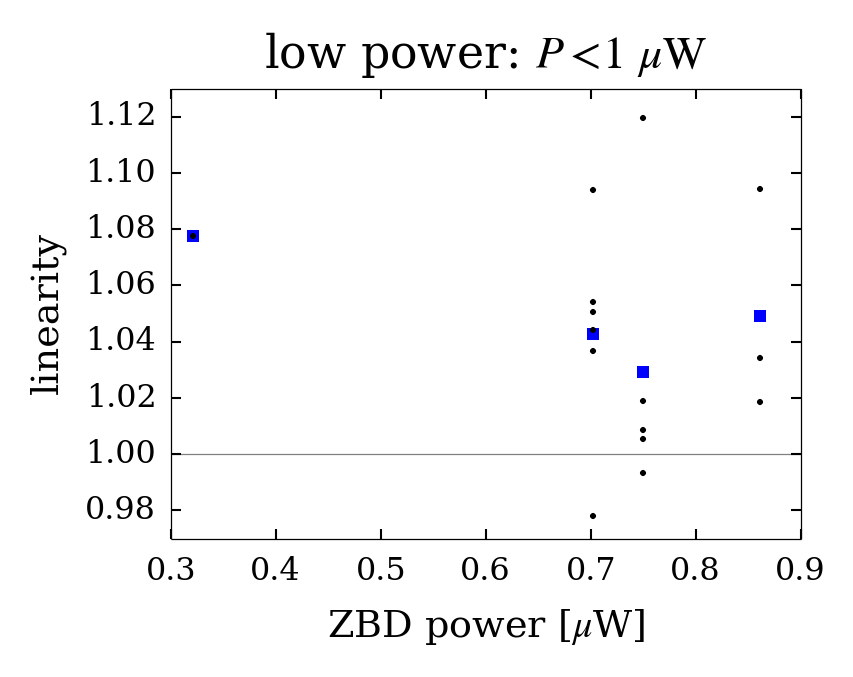

In [21]:
fig, ax = plt.subplots()
ax.axhline(1, color='gray')

for index, row in df[df.is_low].iterrows():
#    ax.errorbar(1e6 * row.zbd_power, row.linearity, yerr=row.linearity_error,
    ax.plot(1e6 * row.zbd_power, row.linearity,
                marker='s', color='blue', linestyle='none', markeredgecolor='none')

for r in low_rectangles:
    ax.plot(1e6 * r[3], r[4], '.k', ms=2)
ax.set_ylim(0.97, 1.13)

ax.set_xlabel('ZBD power [$\mu$W]')
ax.set_ylabel('linearity')
ax.set_title(r'low power: $P < 1 \, \mu \mathrm{W}$');

# Calibrate the high-power points using the linear region

In [22]:
high_rectangles = []
linear_mickey = np.unique(df[df.is_linear].mickey)
linear_minnie = np.unique(df[df.is_linear].minnie)
for index, row in df[df.is_high].iterrows():
    row_linearity = []
    for L1 in linear_mickey[linear_mickey > row.mickey]:
        for L2 in linear_minnie[linear_minnie > row.minnie]:
            HH, HL, LH, LL = rectangle(df, row.mickey, L1, row.minnie, L2)
            try:
                if (LL.iloc[0].is_linear and
                    HL.iloc[0].is_linear and
                    LH.iloc[0].is_linear):
                    linearity = ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                 (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))
                    high_rectangles.append((HH.iloc[0].zbd_power,
                                            HL.iloc[0].zbd_power,
                                            LH.iloc[0].zbd_power,
                                            LL.iloc[0].zbd_power,
                                            linearity))
                    row_linearity.append(linearity)
            except IndexError:
                continue
    if len(row_linearity):
        df.loc[index, 'linearity_0'] = np.mean(row_linearity)
        df.loc[index, 'linearity_0_error'] = np.std(row_linearity)  # / len(row_linearity)**(1/2)
        df.loc[index, 'zbd_power_linear_0'] = row.zbd_power / np.mean(row_linearity)

len(high_rectangles)

27

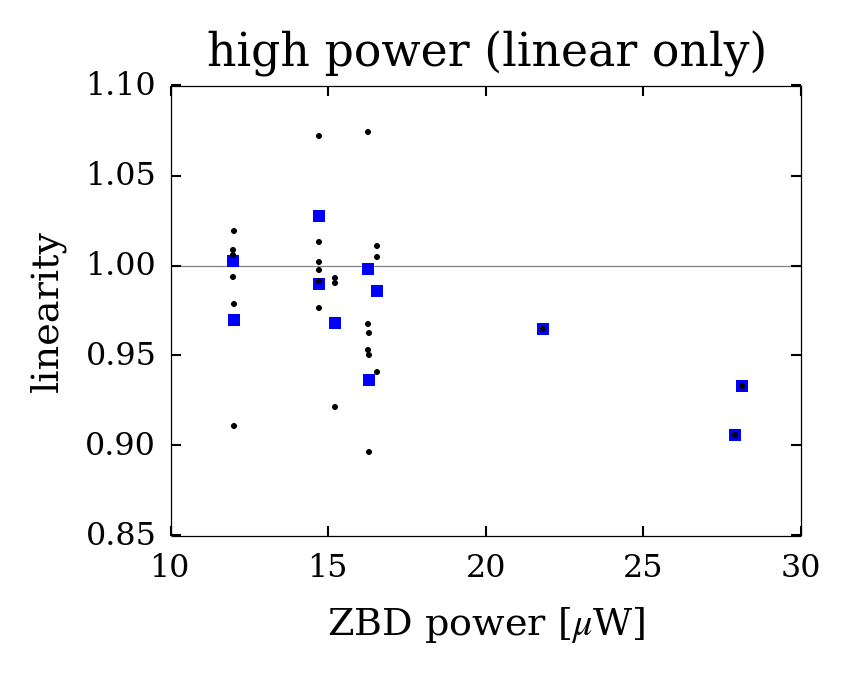

In [23]:
fig, ax = plt.subplots()
ax.axhline(1, color='gray')

for index, row in df[df.is_high].iterrows():
#    ax.errorbar(1e6 * row.zbd_power, row.linearity, yerr=row.linearity_error,
    ax.plot(1e6 * row.zbd_power, row.linearity_0,
                marker='s', color='blue', linestyle='none', markeredgecolor='none')

for r in high_rectangles:
    ax.plot(1e6 * r[0], r[4], '.k', ms=2)

ax.set_xlabel('ZBD power [$\mu$W]')
ax.set_ylabel('linearity')
ax.set_title('high power (linear only)');

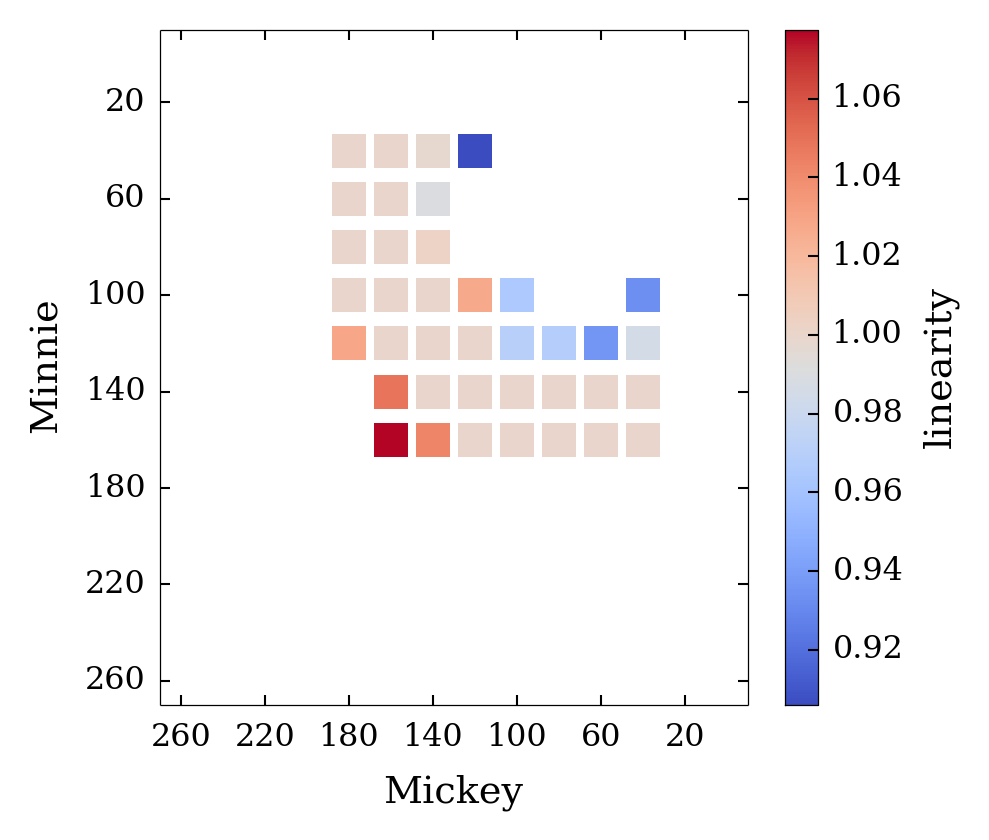

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 3))
data = np.unique(np.concatenate((df.linearity, df.linearity_0)))
norm = matplotlib.colors.Normalize
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df[~df.linearity.isnull()].iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.linearity),
            marker='s', markersize=8, markeredgecolor='none')
for n, row in df[~df.linearity_0.isnull()].iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.linearity_0),
            marker='s', markersize=8, markeredgecolor='none')
ax.set_xlim(270, -10)
ax.set_xticks(range(260, -20, -40))
ax.set_ylim(270, -10)
ax.set_yticks(range(260, -20, -40))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie')
fig.colorbar(mappable, label='linearity');

# Calibrate the high-power points using the linear region and the linearized low-power data

In [25]:
# Now use the linearized low-power points.

high_rectangles_2 = []
linear_mickey = np.unique(df[~df.zbd_power_linear.isnull()].mickey)
linear_minnie = np.unique(df[~df.zbd_power_linear.isnull()].minnie)
for index, row in df[df.is_high].iterrows():
    row_linearity = []
    for L1 in linear_mickey[linear_mickey > row.mickey]:
        for L2 in linear_minnie[linear_minnie > row.minnie]:
                HH, HL, LH, LL = rectangle(df, row.mickey, L1, row.minnie, L2)
                try:
                    HH0 = HH.iloc[0]
                    HL0 = HL.iloc[0]
                    LH0 = LH.iloc[0]
                    LL0 = LL.iloc[0]
                    if ((HL0.is_linear or HL0.is_low) and ~np.isnan(HL0.zbd_power_linear) and
                        (LH0.is_linear or LH0.is_low) and ~np.isnan(LH0.zbd_power_linear) and
                        (LL0.is_linear or LL0.is_low) and ~np.isnan(LL0.zbd_power_linear)):
                        linearity = ((HH0.zbd_power * LL0.zbd_power_linear) /
                                     (HL0.zbd_power_linear * LH0.zbd_power_linear))
                        high_rectangles_2.append((HH0.zbd_power,
                                                  HL0.zbd_power_linear,
                                                  LH0.zbd_power_linear,
                                                  LL0.zbd_power_linear,
                                                  linearity))
                        row_linearity.append(linearity)
                except IndexError:
                    continue
    if len(row_linearity):
        df.loc[index, 'linearity'] = np.mean(row_linearity)
        df.loc[index, 'linearity_error'] = np.std(row_linearity)  # / len(row_linearity)**(1/2)
        df.loc[index, 'zbd_power_linear'] = row.zbd_power / np.mean(row_linearity)

len(high_rectangles_2)

69

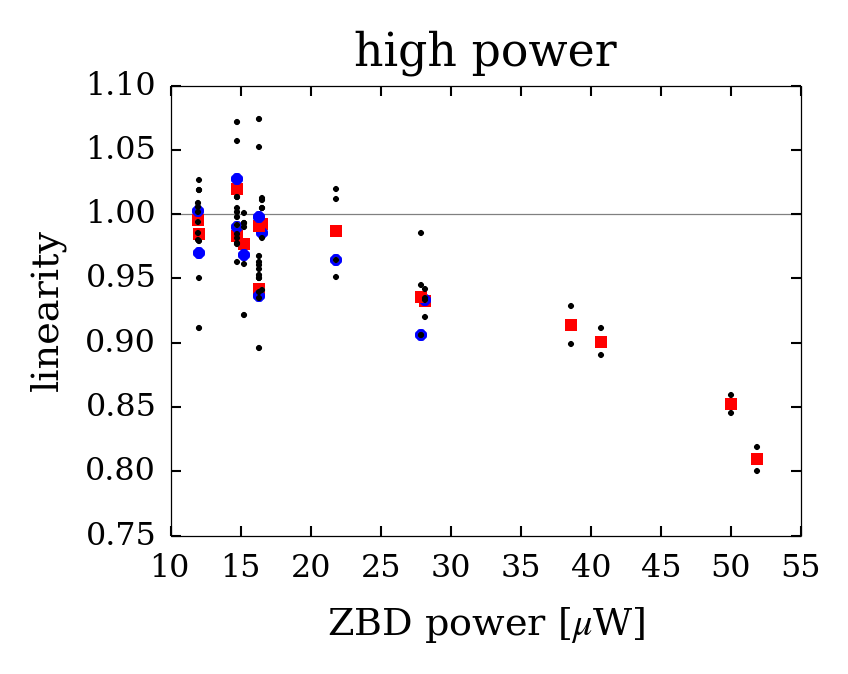

In [26]:
fig, ax = plt.subplots()
ax.axhline(1, color='gray')

for index, row in df[df.is_high].iterrows():
#    ax.errorbar(1e6 * row.zbd_power, row.linearity, yerr=row.linearity_error,
    ax.plot(1e6 * row.zbd_power, row.linearity,
                marker='s', color='red', linestyle='none', markeredgecolor='none')
    ax.plot(1e6 * row.zbd_power, row.linearity_0,
                marker='o', color='blue', linestyle='none', markeredgecolor='none')

#zp = 1e-6 * np.linspace(10, 55, 1e3)
#ax.plot(1e6 * zp,
#        np.polyval(np.polyfit(df[df.is_high].zbd_power, df[df.is_high].linearity, 2), zp),
#        '-r')
    
for r in high_rectangles:
    ax.plot(1e6 * r[0], r[4], '.', color='gray', ms=2)

for r in high_rectangles_2:
    ax.plot(1e6 * r[0], r[4], '.k', ms=2)

ax.set_xlabel('ZBD power [$\mu$W]')
ax.set_ylabel('linearity')
ax.set_title('high power');

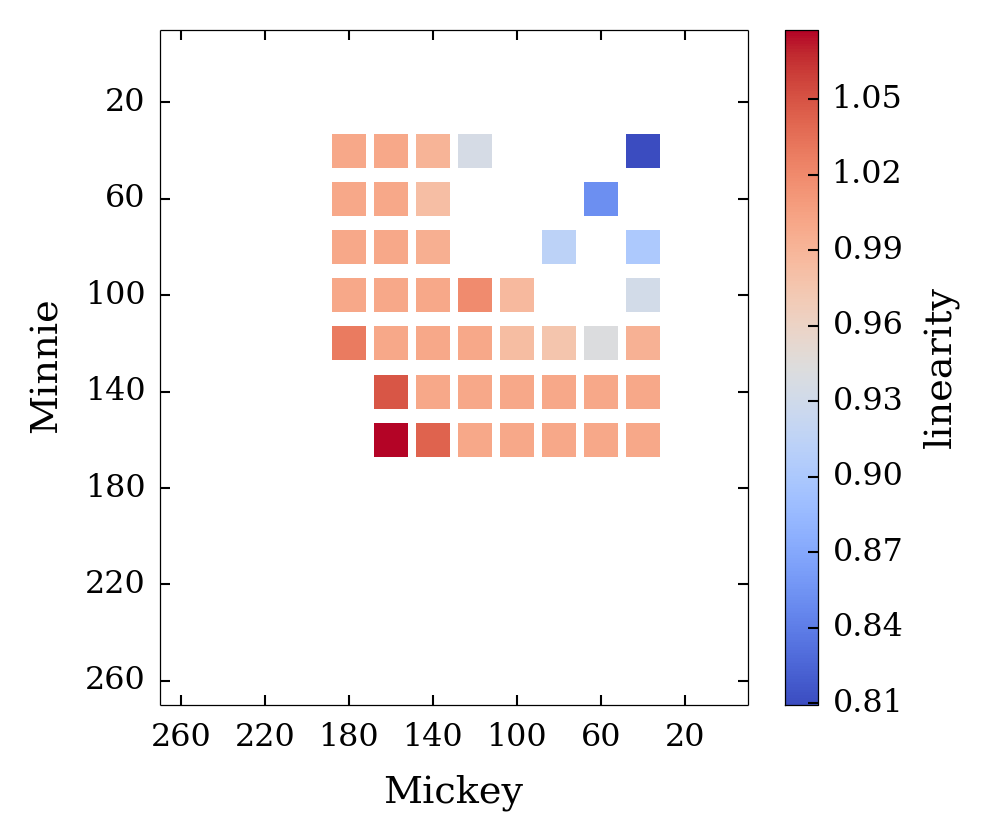

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 3))
data = df.linearity
norm = matplotlib.colors.Normalize
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df[~df.linearity.isnull()].iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.linearity),
            marker='s', markersize=8, markeredgecolor='none')
ax.set_xlim(270, -10)
ax.set_xticks(range(260, -20, -40))
ax.set_ylim(270, -10)
ax.set_yticks(range(260, -20, -40))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie')
fig.colorbar(mappable, label='linearity');

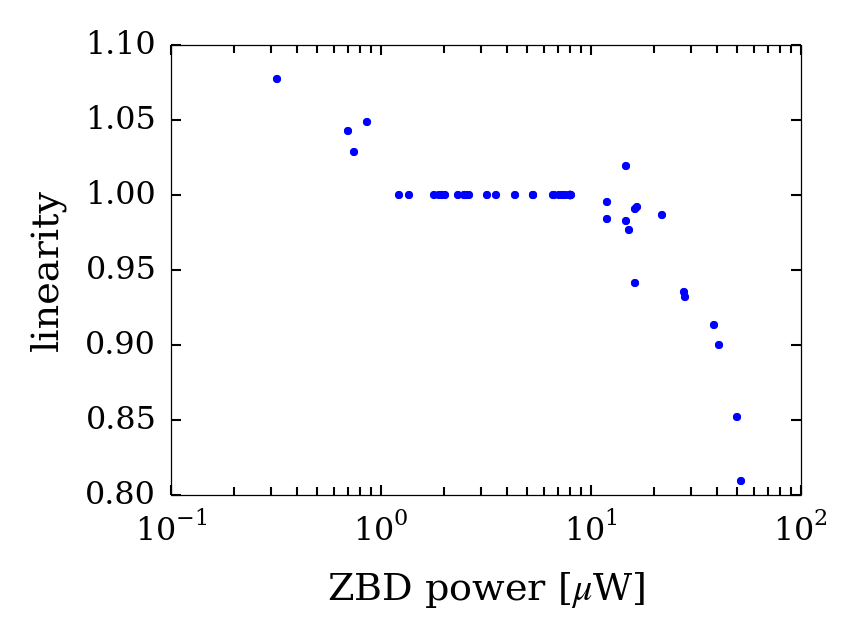

In [28]:
plt.semilogx(1e6 * df.zbd_power, df.linearity, '.')
plt.xlabel('ZBD power [$\mu$W]')
plt.ylabel('linearity');

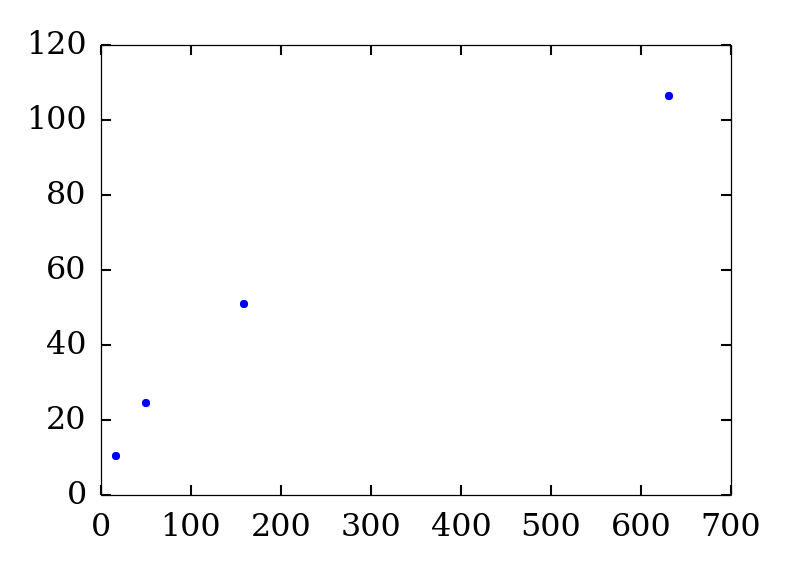

In [33]:
V = []
P = []
P.append(1e-3 * 10**(-18/10))
V.append(23e-3)

P.append(1e-3 * 10**(-13/10))
V.append(54e-3)

P.append(1e-3 * 10**(-8/10))
V.append(112e-3)

P.append(1e-3 * 10**(-2/10))
V.append(234e-3)

P = np.array(P)
V = np.array(V)

plt.plot(1e6 * P, 1e6 * zbd_power(lockin_rms_voltage(V), optical_frequency=None), '.')

In [34]:
10**(1/2) / 20 / 10

0.015811388300841896

In [35]:
1e-3 * 10**(-25/10)

3.1622776601683796e-06